# Introdução à Computação Visual
## TP1 - Compressor
* Gabriel Person
* Lucas Mundim

Implementação de um compressor de imagens usando `python 3.6` e `OpenCV 3.4.3` para a disciplina *Introdução à Computação Visual* - UFMG 2018/2

---
A ideia geral do compressor a ser implementado é fundir a compressão de dois métodos conhecidos:
* Comprimento de corrida
* Compressão psicovisual

In [17]:
import os
import cv2
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

print('Python: ', os.sys.version)
print('OpenCV: ', cv2.__version__)

Python:  3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
OpenCV:  3.4.3


## Compressão Psicovisual

Esse método de compressão busca explorar a imprecisão do sistema visual humano em perceber detalhes. Ele consiste em reduzir o número de bits na profundidade da imagem, reduzindo portanto o tamanho codificado da imagem a ser armazenado.

In [18]:
# Compressão psicovisual
def calcEntropy(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()

    return entropy

# Calculo da PSNR (Peak Signal-to-Noise Ratio)
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

Foi escolhida uma compressão para a profundidade de *4 bits*. De uma forma geral, 4 bits de profundidade (2⁴ = 16 tons de cinza) são suficientes para representar bem uma imagem em *grey-scale*, como pode ser visto abaixo:

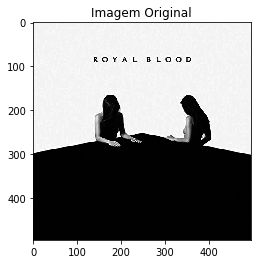

Entropia: 2.4657914638519287


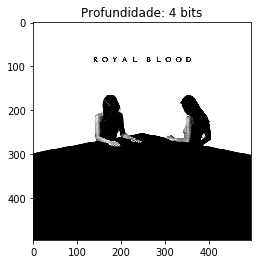

Entropia: 1.2206279039382935
Eficiencia:  0.30515697598457336
PSNR: 35.391


In [19]:
# original = 8 bits
#filename = "tiger.jpg"
#filename = "HowDidWeGetSoDark.jpg"
filename = "HowDidWeGetSoDark.pgm"
#filename = "band.jpg"

original = cv2.imread(filename, 0)

plt.title('Imagem Original')
plt.imshow(original, cmap = 'gray')
plt.show()
print ('Entropia:', calcEntropy(original))
calcEntropy(original)


# 4 bits
entropyCompressed = original & 0xf0
plt.title('Profundidade: 4 bits')
plt.imshow(entropyCompressed, cmap = 'gray')
plt.show()
print ('Entropia:', calcEntropy(entropyCompressed))
print ('Eficiencia: ', calcEntropy(entropyCompressed)/4)
print ("PSNR: %5.3f" % psnr(original, entropyCompressed))
mpimg.imsave("entropyCompressed.jpg", entropyCompressed, 0, 255, cmap='gray')

## Comprimento de Corrida

Para fins de testes, foi implementado um exemplo de compressão de comprimento de corrida. Não foi implementado um descompressor pois mesmo em imagens com poucas bordas (ex: `HowDidWeGetSoDark.jpg`) a compressão foi pior que o tamanho original.

Em exemplos de imagens no formato `.pgm` (ex: `HowDidWeGetSoDark.pgm`) essa compressão foi efetiva. Contudo, ainda foi *menos* efetiva que a compressão psicovisual feita no passo anterior.

Vale ressaltar que o comprimento de corrida foi aplicado na imagem *já comprimida pelo passo psicovisual anterior*, o que atenua o baixo fator de compressão conquistado.

In [20]:
run = 0
current = entropyCompressed[0][0]
runCompress = []
runIndex = 0
height = len(entropyCompressed)
width = len(entropyCompressed[0])

for i in range(0, height):
    for j in range(0, width):
        if entropyCompressed[i][j]==current:
            run = run+1
        else:
            runCompress.append("(%d, %d)" % (current, run))
            current = entropyCompressed[i][j]
            run = 1
    runCompress.append("(%d, %d)" % (current, run))
    run = 0
    runCompress.append("\n")
    if i+1 < height:
        current = entropyCompressed[i+1][0] 
        
file = open("entropyAndRun.txt","w+")
for i in runCompress:
    file.write(i)
file.close()

Para efeitos de curiosidade, a compressão usando comprimento de corrida foi testada também sobre a imagem original e, como esperado, os resultados foram ruins, obtendo um arquivo maior que o original.

In [21]:
run = 0
current = original[0][0]
runCompress = []
runIndex = 0
height = len(original)
width = len(original[0])

for i in range(0, height):
    for j in range(0, width):
        if original[i][j]==current:
            run = run+1
        else:
            runCompress.append("(%d, %d)" % (current, run))
            current = original[i][j]
            run = 1
    runCompress.append("(%d, %d)" % (current, run))
    run = 0
    runCompress.append("\n")
    if i+1 < height:
        current = original[i+1][0]
        
file = open("run.txt","w+")
for i in runCompress:
    file.write(i)
file.close()

## Conclusão

De acordo com testes realizados, a compressão de imagens em cadeia só é, no máximo, tão eficiente quanto a mais eficiente aplicada. Portanto, a proposta inicial de encadear c